In [1]:
import pandas as pd
import joblib
from data_processing.main import read_scoreset
from tqdm import tqdm
from pathlib import Path
from data_processing.mapping_nbs import mapping_utils
from data_processing.mapping_nbs import plotting
pd.set_option('display.max_columns', 500)

dataset_name = "Kato_TP53_NOXAnWT"
dataset_path = Path("/data/dzeiberg/mave_calibration/data/") / dataset_name
assert dataset_path.exists()

In [2]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = mapping_utils.load_mapping_data()

In [3]:
scoreset = read_scoreset(dataset_path / "scoreset.csv")

In [4]:
scoreset

,ProtDescription,AAchange,Codon_Number,WAF1nWT,MDM2nWT,BAXnWT,h1433snWT,AIP1nWT,GADD45nWT,score,P53R2nWT,WAF1nWT_Saos2,MDM2nWT_Saos2,BAXnWT_Saos2,h1433snWT_Saos2,AIP1nWT_Saos2,PUMAnWT_Saos2,SubG1nWT_Saos2,Oligomerisation_yeast,hgvs_pro,synonymous,nonsense
0,p.A119D,A119D,119,24.5,15.4,13.5,7.9,4.6,53.2,9.7,91.6,33.3,74.1,2.6,18.8,-1.8,154.9,142.2,NaN,p.Ala119Asp,False,False
1,p.A119G,A119G,119,53.5,24.0,14.1,50.8,27.5,91.6,122.7,109.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p.Ala119Gly,False,False
2,p.A119P,A119P,119,29.8,17.3,12.4,43.7,21.9,81.0,107.2,116.6,62.6,104.2,80.2,108.1,38.1,139.3,106.6,NaN,p.Ala119Pro,False,False
3,p.A119S,A119S,119,101.2,56.6,43.1,92.9,48.6,91.9,138.9,106.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p.Ala119Ser,False,False
4,p.A119T,A119T,119,108.2,100.4,102.8,87.0,52.8,86.1,115.8,94.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p.Ala119Thr,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2309,p.Y327D,Y327D,327,92.8,110.3,109.1,134.6,111.5,74.2,104.2,90.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TETR,p.Tyr327Asp,False,False
2310,p.Y327F,Y327F,327,103.1,140.6,137.3,144.9,116.4,109.3,146.1,113.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TETR,p.Tyr327Phe,False,False
2311,p.Y327H,Y327H,327,82.7,107.3,100.1,97.5,96.3,84.6,146.6,109.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TETR,p.Tyr327His,False,False
2312,p.Y327N,Y327N,327,97.0,137.4,104.9,120.8,124.3,91.1,161.1,118.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TETR,p.Tyr327Asn,False,False


In [5]:
if "author_transcript" not in scoreset.columns or scoreset.author_transcript.isna().all():
    AUTHOR_TRANSCRIPT = gene_info.loc[metadata.loc[dataset_name],'MANE_RefSeq_nuc'].values[0].split(".")[0]
else:
    AUTHOR_TRANSCRIPT = scoreset.author_transcript.iloc[0].split(".")[0]

In [6]:
AUTHOR_TRANSCRIPT

'NM_000546'

# Add ClinVar annotations

In [7]:
clinvar_hgvs_pro_summaries = mapping_utils.get_clinvar_summaries(clinvar_df,AUTHOR_TRANSCRIPT)

  0%|          | 0/1612 [00:00<?, ?it/s]

100%|██████████| 1612/1612 [00:00<00:00, 2082.01it/s]


In [8]:
scoreset_w_clinvar = pd.merge(scoreset.set_index("hgvs_pro"),clinvar_hgvs_pro_summaries,
                            left_index=True,
                            right_index=True,
                            how="left",
                            validate="one_to_one",
                            suffixes=("","_clinvar"))

# Add gnomAD annotations

In [9]:
Ensembl_transcript_stable_ids = mapping_utils.translate_refseq_to_ensembl(AUTHOR_TRANSCRIPT)

In [10]:
Ensembl_transcript_stable_ids

array(['ENST00000269305'], dtype=object)

In [11]:
gnomAD_info = mapping_utils.gather_gnomAD_info(gnomAD_df,Ensembl_transcript_stable_ids,[AUTHOR_TRANSCRIPT,])

In [12]:
scoreset_processed = pd.merge(scoreset_w_clinvar,gnomAD_info,
                                        left_index=True,right_index=True,how="left",validate="one_to_one").reset_index()

In [13]:
scoreset_processed

,hgvs_pro,ProtDescription,AAchange,Codon_Number,WAF1nWT,MDM2nWT,BAXnWT,h1433snWT,AIP1nWT,GADD45nWT,score,P53R2nWT,WAF1nWT_Saos2,MDM2nWT_Saos2,BAXnWT_Saos2,h1433snWT_Saos2,AIP1nWT_Saos2,PUMAnWT_Saos2,SubG1nWT_Saos2,Oligomerisation_yeast,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max,gnomAD_variants_maxAC_AF,gnomAD_variants_max_spliceAI_score,gnomAD_variants_VCF_INFO
0,p.Ala119Asp,p.A119D,A119D,119,24.5,15.4,13.5,7.9,4.6,53.2,9.7,91.6,33.3,74.1,2.6,18.8,-1.8,154.9,142.2,NaN,False,False,0.0,0.0,0.0,1.0,NM_000546.6(TP53):c.356C>A (p.Ala119Asp),1.0,0.01,NaN,NaN,NaN
1,p.Ala119Gly,p.A119G,A119G,119,53.5,24.0,14.1,50.8,27.5,91.6,122.7,109.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.0,0.0,1.0,0.0,NM_000546.6(TP53):c.356C>G (p.Ala119Gly),1.0,0.82,NaN,NaN,NaN
2,p.Ala119Pro,p.A119P,A119P,119,29.8,17.3,12.4,43.7,21.9,81.0,107.2,116.6,62.6,104.2,80.2,108.1,38.1,139.3,106.6,NaN,False,False,0.0,0.0,0.0,1.0,NM_000546.6(TP53):c.355G>C (p.Ala119Pro),1.0,0.01,NaN,NaN,NaN
3,p.Ala119Ser,p.A119S,A119S,119,101.2,56.6,43.1,92.9,48.6,91.9,138.9,106.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p.Ala119Thr,p.A119T,A119T,119,108.2,100.4,102.8,87.0,52.8,86.1,115.8,94.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.849430e-07,0.0,17:7676014:C:T|17:7676014:C:T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2309,p.Tyr327Asp,p.Y327D,Y327D,327,92.8,110.3,109.1,134.6,111.5,74.2,104.2,90.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TETR,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2310,p.Tyr327Phe,p.Y327F,Y327F,327,103.1,140.6,137.3,144.9,116.4,109.3,146.1,113.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TETR,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2311,p.Tyr327His,p.Y327H,Y327H,327,82.7,107.3,100.1,97.5,96.3,84.6,146.6,109.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TETR,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2312,p.Tyr327Asn,p.Y327N,Y327N,327,97.0,137.4,104.9,120.8,124.3,91.1,161.1,118.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TETR,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
scoreset_processed.to_csv(dataset_path / "scoreset_processed.csv",index=False)

# Reload Processed

In [15]:
scoreset_processed = pd.read_csv(dataset_path / "scoreset_processed.csv")

In [16]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    return r.gnomAD_variants_maxAC_AF > 0 and r.gnomAD_variants_max_spliceAI_score <= .5

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5



In [17]:
sample_data = {
    "P/LP" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_pathogenic(r),axis=1)],
    "B/LB" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_benign(r),axis=1)],
    'gnomAD': scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_gnomAD(r),axis=1)],
    'synonymous' : scoreset_processed[scoreset_processed.apply(is_synonymous,axis=1)],
}
sample_data = {k : v for k,v in sample_data.items() if len(v)}

INVERT_SCORES = False
if INVERT_SCORES:
    for k in sample_data:
        sample_data[k] = sample_data[k].assign(score= -sample_data[k].score)

In [18]:
for sample_name, sample in sample_data.items():
    print(f"{sample_name}: {sample.shape[0]}")

P/LP: 170
B/LB: 100
gnomAD: 481


(<Figure size 1200x900 with 3 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>], dtype=object))

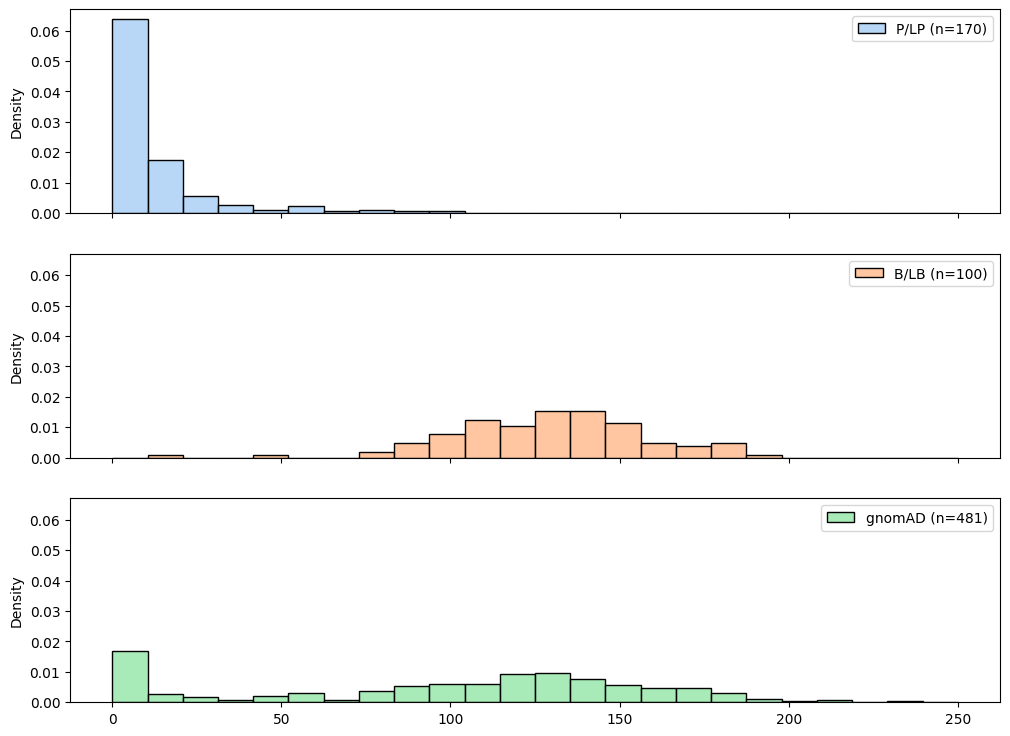

In [19]:
plotting.plot_samples({k : v.score.values for k,v in sample_data.items()})

In [20]:
pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                            *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                            *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)